Fraud Detection Using KNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix, make_scorer, roc_curve, roc_auc_score, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression, SGDClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from scipy.stats import uniform, randint
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearnex import patch_sklearn 
patch_sklearn()

import warnings
warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


General information about the data:

In [2]:
credit_card=pd.read_csv("creditcard.csv")
print(credit_card.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [3]:
print(credit_card.dtypes)

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


Class needed to be categorical.

In [4]:
credit_card["Class"]=credit_card["Class"].astype("category")

Let' see if there are any null.

In [5]:
print(credit_card.isna().any().sum())

0


Let's see how many transactions are fraudulent.

In [6]:
credit_card["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Text(0.5, 1.0, 'Distribution of credit card frauds \n (0: No Fraud || 1: Fraud)')

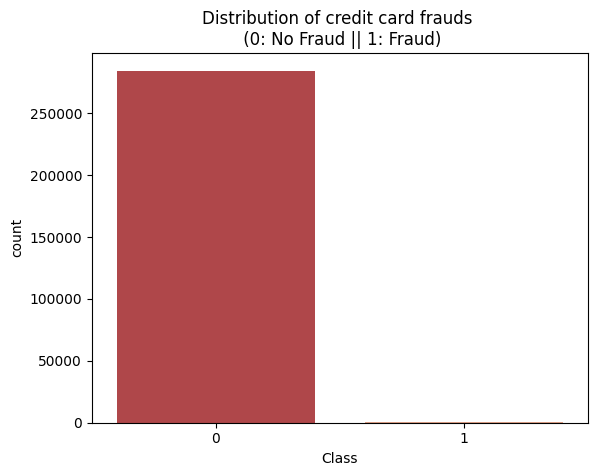

In [7]:
sns.set_palette("RdBu")
bar = sns.countplot(x=credit_card["Class"])
bar.set_title('Distribution of credit card frauds \n (0: No Fraud || 1: Fraud)')

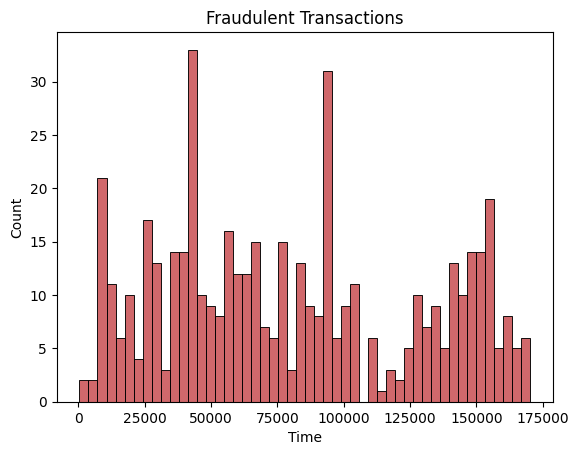

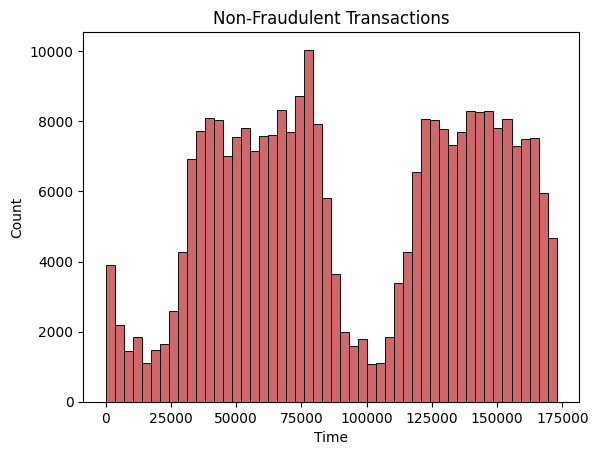

In [8]:
g1 = sns.histplot(credit_card["Time"][credit_card.Class == 1], bins=50)
g1.set_title("Fraudulent Transactions")
plt.show()
g1 = sns.histplot(credit_card["Time"][credit_card.Class == 0], bins=50)
g1.set_title("Non-Fraudulent Transactions")
plt.show()

Text(0.5, 1.0, 'Distribution of Transaction Amount')

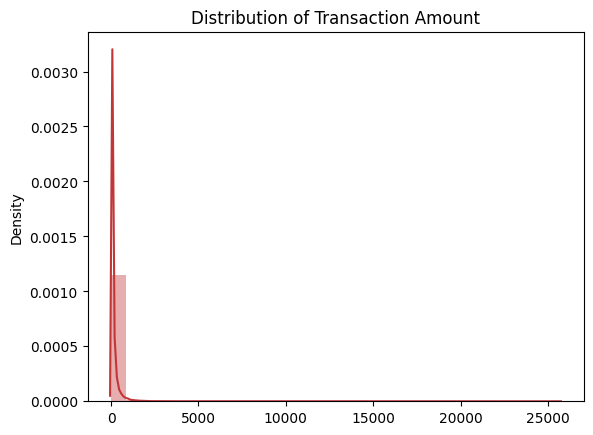

In [9]:
amount_v=credit_card["Amount"]
rel = sns.distplot(x=credit_card["Amount"],bins=30)
rel.set_title('Distribution of Transaction Amount')

Check if any Nan exist.

In [10]:
X = credit_card.drop("Class", axis=1).values
y=credit_card["Class"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=41, stratify=y)

In [11]:
#Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
results= pd.DataFrame(columns=["Function Name", "Accuracy", "Precision", "Recall",
                               "F1", "TN", "FP", "FN", "TP", "ROC-AUC score"])

In [36]:
def print_scores(models, X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, y_test=y_test,
                 result_prefix="",results=results):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(model.__class__.__name__)
        y_pred = np.round(y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        try:
            roc_auc = roc_auc_score(y_test,model.predict_proba(X_test)[:, 1])
            index_to_insert=(len(results.index) if results[results["Function Name"] == model.__class__.__name__].index.empty
                                            else results[results["Function Name"] == model.__class__.__name__].index[0] )
            results.loc[index_to_insert] = [model.__class__.__name__+result_prefix, accuracy,
                                               precision, recall, f1, tn, fp, fn, tp,roc_auc] 
        except:
            index_to_insert=(len(results.index) if results[results["Function Name"] == model.__class__.__name__].index.empty
                                                else results[results["Function Name"] == model.__class__.__name__].index[0] )
            results.loc[index_to_insert] = [model.__class__.__name__+result_prefix, accuracy,
                                               precision, recall, f1, tn, fp, fn, tp,None] 
        fig, ax = plt.subplots(figsize=(2.5,2.5))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
        plt.show()
        print(classification_report(y_test, y_pred))

In [15]:
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) #We use stratified becuse of imbalanced dataset. 

In [16]:
def tune_leg_reg(X=X_train_scaled, y=y_train, scoring="f1", cv=kf):
    log_reg_params = {"solver" : [ "liblinear", "sag", "saga"],
                      'C': [0.001, 0.01, 0.1, 1, 10, 500],
                      "class_weight": [{0:1, 1:80}, {0:1, 1:40}, "balanced"]}
    grid_log_reg = RandomizedSearchCV(LogisticRegression(max_iter=10000,n_jobs=-1),
                                      log_reg_params, cv=kf, n_iter=20, n_jobs=-1, scoring=scoring, verbose=3)
    grid_log_reg.fit(X, y)
    return grid_log_reg.best_estimator_

In [17]:
def tune_dec_tree(X=X_train_scaled, y=y_train, scoring="f1", cv=kf):
    tree_params = {"criterion": ["gini", "entropy"],
                   "max_depth": list(range(2,4,1)),
                   "min_samples_leaf": list(range(5,7,1)), 
                   "class_weight": [{0:1, 1:80}, {0:1, 1:40}, "balanced"]}
    grid_tree = RandomizedSearchCV(DecisionTreeClassifier(),
                                    tree_params, cv=kf, n_iter=8, n_jobs=-1,scoring=scoring, verbose=3)
    grid_tree.fit(X_train_scaled, y_train)
    return grid_tree.best_estimator_

In [18]:
def tune_knn(X=X_train_scaled, y=y_train, scoring="f1", cv=kf):
    knears_params = {"n_neighbors": list(range(2,5,1)), 
                     'weights' : ['uniform','distance'],
                     'metric' : ['minkowski','euclidean','manhattan']}
    grid_knears = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1), knears_params, cv=kf, n_iter=20, scoring=scoring, verbose=3)
    grid_knears.fit(X_train_scaled, y_train)
    return grid_knears.best_estimator_

In [19]:
def tune_sgd(X=X_train_scaled, y=y_train, scoring="f1", cv=kf):
    from skopt.space import Real, Categorical, Integer
    loss = ['log', 'modified_huber']
    penalty = ['l1', 'l2', 'elasticnet']
    alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
    learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
    class_weight = [{0:1, 1:80}, {0:1, 1:40}, "balanced"]
    eta0 = [1, 10, 100] 
    param_distributions = dict(loss=loss, 
                                penalty=penalty, 
                                alpha=alpha, 
                                learning_rate=learning_rate, 
                                class_weight=class_weight, 
                                eta0=eta0) 
    grid_sgd = RandomizedSearchCV(SGDClassifier(),param_distributions, cv=kf, n_iter=40, n_jobs=-1,scoring=scoring, verbose=3)
    grid_sgd.fit(X_train_scaled, y_train)
    return grid_sgd.best_estimator_

In [20]:
def tune_xgb(X=X_train_scaled,y=y_train, scoring="f1", cv=kf):
    params = {
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 0.5),
        "learning_rate": uniform(0.03, 0.3),
        "max_depth": randint(2, 6),
        "n_estimators": randint(100, 150),
        "subsample": uniform(0.6, 0.4)
    }
    grid_xgb = RandomizedSearchCV(xgb.XGBClassifier(objective="binary:logistic",n_jobs=-1), params, cv=kf, n_iter=20,
                                  scoring=scoring)
    grid_xgb.fit(X_train_scaled, y_train)
    return grid_xgb.best_estimator_

First try with default parameters.

XGBClassifier


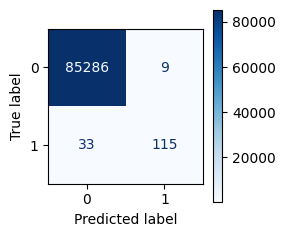

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.78      0.85       148

    accuracy                           1.00     85443
   macro avg       0.96      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443

XGBRFClassifier


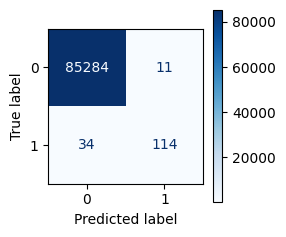

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.77      0.84       148

    accuracy                           1.00     85443
   macro avg       0.96      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443

LogisticRegression


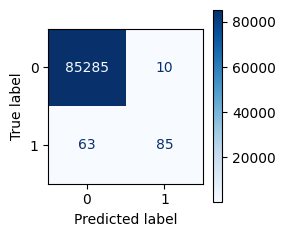

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.57      0.70       148

    accuracy                           1.00     85443
   macro avg       0.95      0.79      0.85     85443
weighted avg       1.00      1.00      1.00     85443

KNeighborsClassifier


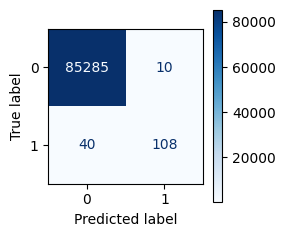

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.92      0.73      0.81       148

    accuracy                           1.00     85443
   macro avg       0.96      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443

DecisionTreeClassifier


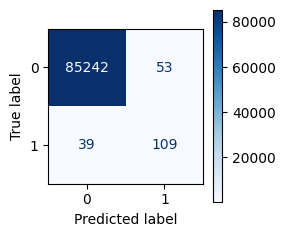

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.67      0.74      0.70       148

    accuracy                           1.00     85443
   macro avg       0.84      0.87      0.85     85443
weighted avg       1.00      1.00      1.00     85443

SGDClassifier


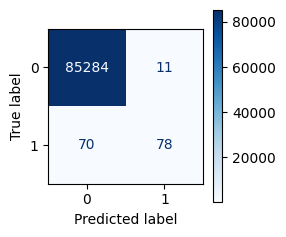

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.53      0.66       148

    accuracy                           1.00     85443
   macro avg       0.94      0.76      0.83     85443
weighted avg       1.00      1.00      1.00     85443



In [39]:
models = {"XGB Classifier": xgb.XGBClassifier(n_jobs=-1, tree_method="hist"),
          "XGB Random Forest Classifier": xgb.XGBRFClassifier(n_jobs=-1, tree_method="hist"),
          "Logistic Regression": LogisticRegression(n_jobs=-1),
          "KNN": KNeighborsClassifier(n_jobs=-1), 
          "Decision Tree": DecisionTreeClassifier(),
          "SGD": SGDClassifier(n_jobs=-1, loss="log_loss")}
print_scores(models)

Then arrange class weight.

XGBClassifier


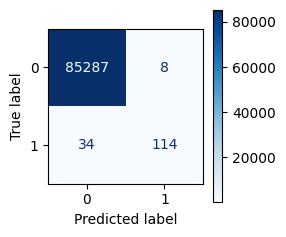

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.77      0.84       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443

XGBRFClassifier


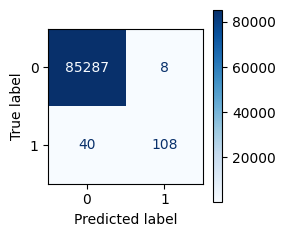

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.73      0.82       148

    accuracy                           1.00     85443
   macro avg       0.97      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443

LogisticRegression


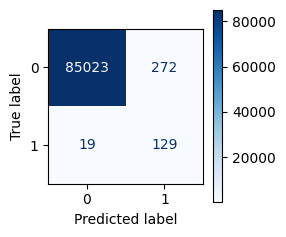

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.32      0.87      0.47       148

    accuracy                           1.00     85443
   macro avg       0.66      0.93      0.73     85443
weighted avg       1.00      1.00      1.00     85443

KNeighborsClassifier


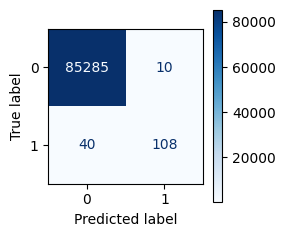

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.92      0.73      0.81       148

    accuracy                           1.00     85443
   macro avg       0.96      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443

DecisionTreeClassifier


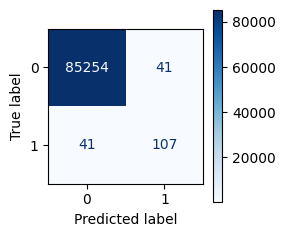

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.72      0.72      0.72       148

    accuracy                           1.00     85443
   macro avg       0.86      0.86      0.86     85443
weighted avg       1.00      1.00      1.00     85443

SGDClassifier


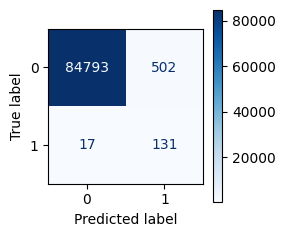

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.21      0.89      0.34       148

    accuracy                           0.99     85443
   macro avg       0.60      0.94      0.67     85443
weighted avg       1.00      0.99      1.00     85443



In [22]:
models = {"XGB Classifier": xgb.XGBClassifier(n_jobs=-1),
          "XGB Random Forest Classifier": xgb.XGBRFClassifier(n_jobs=-1),
          "Logistic Regression": LogisticRegression(n_jobs=-1, class_weight={0:1,1:80}),
          "KNN": KNeighborsClassifier(n_jobs=-1), 
          "Decision Tree": DecisionTreeClassifier(class_weight={0:1,1:80}),
          "SGD": SGDClassifier(n_jobs=-1,class_weight={0:1,1:80}, loss="log_loss")}
print_scores(models, result_prefix="_weighted")

VotingClassifier


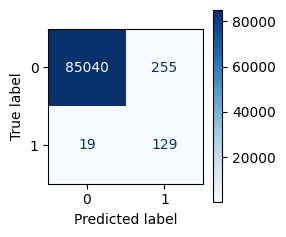

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.34      0.87      0.48       148

    accuracy                           1.00     85443
   macro avg       0.67      0.93      0.74     85443
weighted avg       1.00      1.00      1.00     85443



In [23]:
classifiers=[("XGB Classifier", xgb.XGBClassifier(n_jobs=-1)), 
             ("Logistic Regression", LogisticRegression(n_jobs=-1, class_weight={0:1,1:80})), 
             ("Decision Tree", DecisionTreeClassifier(class_weight={0:1,1:80})),
             ("SGD", SGDClassifier(loss="log_loss", n_jobs=-1,class_weight={0:1,1:80}))]

vc ={"Vote": VotingClassifier(estimators=classifiers,voting="soft",n_jobs=-1,weights=[1,2,1,2]) }    
print_scores(vc, result_prefix="_voting1")

And try Voting Classifier.

VotingClassifier


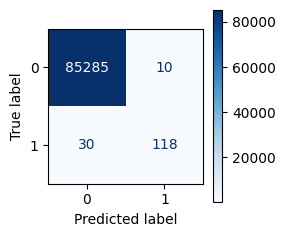

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.92      0.80      0.86       148

    accuracy                           1.00     85443
   macro avg       0.96      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [24]:
classifiers=[("XGB Classifier", xgb.XGBClassifier(n_jobs=-1, tree_method="hist")), 
             ("XGB Random Forest Classifier", xgb.XGBRFClassifier(n_jobs=-1, tree_method="hist")),
             ("Logistic Regression", LogisticRegression(n_jobs=-1, class_weight="balanced")), 
             ("KNN", KNeighborsClassifier(n_jobs=-1)), 
             ("Decision Tree", DecisionTreeClassifier(class_weight="balanced")),
             ("SGD", SGDClassifier(loss="log_loss", n_jobs=-1,class_weight="balanced"))]

vc ={"Vote": VotingClassifier(estimators=classifiers,voting="soft",n_jobs=-1, weights=[1,1,2,1,2,1]) }    
print_scores(vc, result_prefix="_voting2")

Now let's try tuning according to f1 score.

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.833 total time=   4.9s
[CV 2/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.787 total time=   4.9s
[CV 3/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.857 total time=   5.0s
[CV 4/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.882 total time=   4.6s
[CV 1/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.809 total time=   4.0s
[CV 2/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.787 total time=   4.0s
[CV 3/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.847 total time=   4.4s
[CV 4/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.854 total time=   4.5s
[CV 1/4] END metric=minkowski, n_neighbors=3, weights=

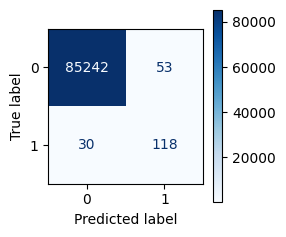

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.69      0.80      0.74       148

    accuracy                           1.00     85443
   macro avg       0.84      0.90      0.87     85443
weighted avg       1.00      1.00      1.00     85443

KNeighborsClassifier


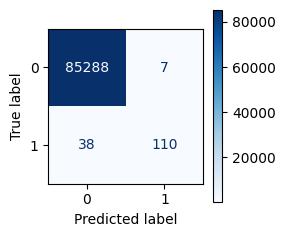

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.74      0.83       148

    accuracy                           1.00     85443
   macro avg       0.97      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443

LogisticRegression


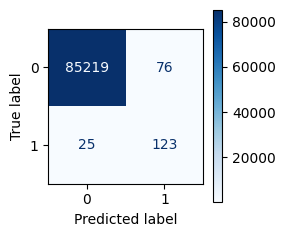

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.62      0.83      0.71       148

    accuracy                           1.00     85443
   macro avg       0.81      0.92      0.85     85443
weighted avg       1.00      1.00      1.00     85443

XGBClassifier


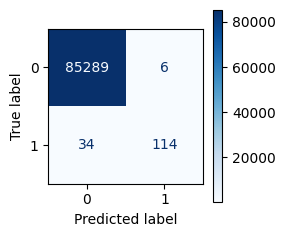

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.77      0.85       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443

SGDClassifier


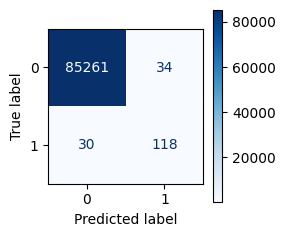

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.78      0.80      0.79       148

    accuracy                           1.00     85443
   macro avg       0.89      0.90      0.89     85443
weighted avg       1.00      1.00      1.00     85443



In [25]:
log_reg_f1 = tune_leg_reg()
tree_clf_f1 = tune_dec_tree()
knears_neighbors_f1 = tune_knn()
xgb_est_f1 = tune_xgb()
sgd_est_f1 = tune_sgd()
models_with_params={"Decision Tree": tree_clf_f1, 
                    "KNN": knears_neighbors_f1,
                    "Logistic Regression": log_reg_f1, 
                    "XGB": xgb_est_f1, 
                    "SGD": sgd_est_f1}
print_scores(models_with_params,result_prefix="_tuned_f1")

VotingClassifier


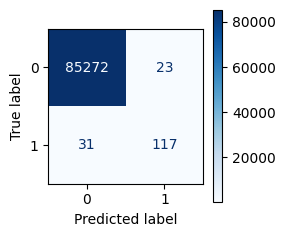

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.84      0.79      0.81       148

    accuracy                           1.00     85443
   macro avg       0.92      0.90      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [26]:
classifiers=[("SGD", sgd_est_f1),
             ("XGB Classifier", xgb_est_f1), 
             ("Logistic Regression", log_reg_f1), 
             ("Decision Tree", tree_clf_f1),
             ("KNN", knears_neighbors_f1)]

vc ={"Vote": VotingClassifier(estimators=classifiers,voting="soft",
                              n_jobs=-1,weights=[2,1,2,1,1]) }#We arranged weights according to results    
print_scores(vc, result_prefix="_voting_tuned_f1")

And recall score.

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.756 total time=   5.1s
[CV 2/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.686 total time=   4.7s
[CV 3/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.767 total time=   5.1s
[CV 4/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.826 total time=   5.0s
[CV 1/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.814 total time=   4.1s
[CV 2/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.733 total time=   4.4s
[CV 3/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.802 total time=   4.5s
[CV 4/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.849 total time=   4.3s
[CV 1/4] END metric=minkowski, n_neighbors=3, weights=

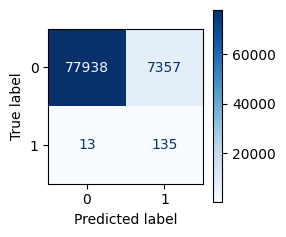

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     85295
           1       0.02      0.91      0.04       148

    accuracy                           0.91     85443
   macro avg       0.51      0.91      0.50     85443
weighted avg       1.00      0.91      0.95     85443

KNeighborsClassifier


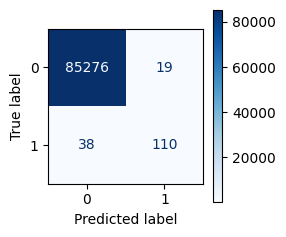

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.74      0.79       148

    accuracy                           1.00     85443
   macro avg       0.93      0.87      0.90     85443
weighted avg       1.00      1.00      1.00     85443

LogisticRegression


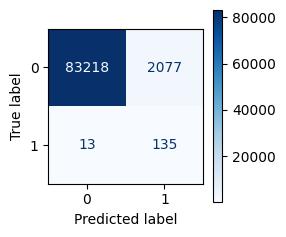

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.91      0.11       148

    accuracy                           0.98     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.98      0.99     85443

XGBClassifier


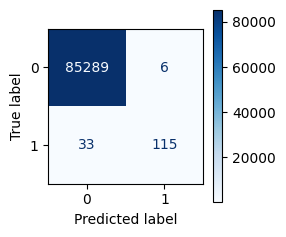

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.78      0.86       148

    accuracy                           1.00     85443
   macro avg       0.98      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443

SGDClassifier


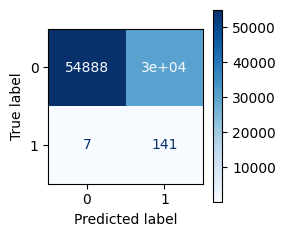

              precision    recall  f1-score   support

           0       1.00      0.64      0.78     85295
           1       0.00      0.95      0.01       148

    accuracy                           0.64     85443
   macro avg       0.50      0.80      0.40     85443
weighted avg       1.00      0.64      0.78     85443



In [27]:
log_reg_rec = tune_leg_reg(scoring="recall")
tree_clf_rec = tune_dec_tree(scoring="recall")
knears_neighbors_rec = tune_knn(scoring="recall")
xgb_est_rec = tune_xgb(scoring="recall")
sgd_est_rec = tune_sgd(scoring="recall")
models_with_params={"Decision Tree": tree_clf_rec,
                    "KNN": knears_neighbors_rec,
                    "Logistic Regression": log_reg_rec, 
                    "XGB": xgb_est_rec, 
                    "SGD": sgd_est_rec}
print_scores(models_with_params,result_prefix="_tuned_rec")

VotingClassifier


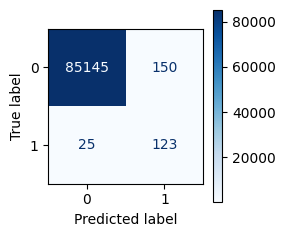

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.45      0.83      0.58       148

    accuracy                           1.00     85443
   macro avg       0.73      0.91      0.79     85443
weighted avg       1.00      1.00      1.00     85443



In [28]:
classifiers = [("SGD", sgd_est_rec),
                   ("XGB Classifier", xgb_est_rec),
                   ("Logistic Regression", log_reg_rec),
                   ("Decision Tree", tree_clf_rec),
                   ("KNN", knears_neighbors_rec)]

vc ={"Vote": VotingClassifier(estimators=classifiers, voting="soft", n_jobs=-1, weights=[2,1,2,1,1]) }    
print_scores(vc, result_prefix="_voting_tuned_rec")

If we apply SMOTE:

In [29]:
method = SMOTE()
X_train_resampled, y_train_resampled = method.fit_resample(X_train_scaled, y_train)

XGBClassifier


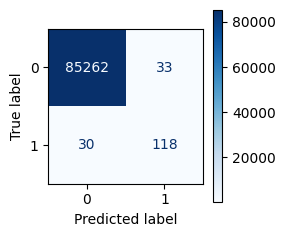

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.78      0.80      0.79       148

    accuracy                           1.00     85443
   macro avg       0.89      0.90      0.89     85443
weighted avg       1.00      1.00      1.00     85443

XGBRFClassifier


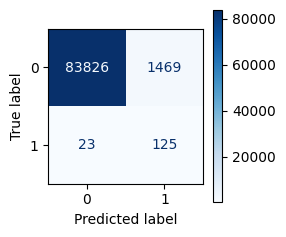

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.08      0.84      0.14       148

    accuracy                           0.98     85443
   macro avg       0.54      0.91      0.57     85443
weighted avg       1.00      0.98      0.99     85443

LogisticRegression


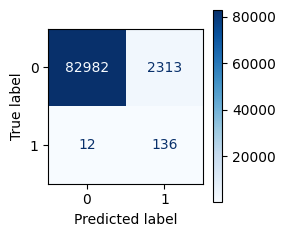

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.92      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.97      0.98     85443

KNeighborsClassifier


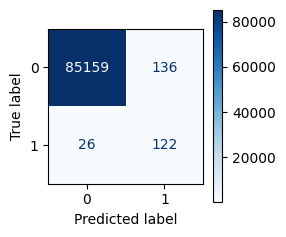

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.47      0.82      0.60       148

    accuracy                           1.00     85443
   macro avg       0.74      0.91      0.80     85443
weighted avg       1.00      1.00      1.00     85443

DecisionTreeClassifier


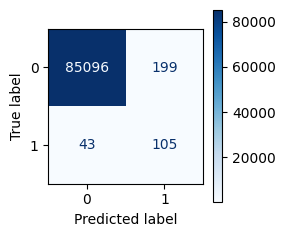

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.35      0.71      0.46       148

    accuracy                           1.00     85443
   macro avg       0.67      0.85      0.73     85443
weighted avg       1.00      1.00      1.00     85443

SGDClassifier


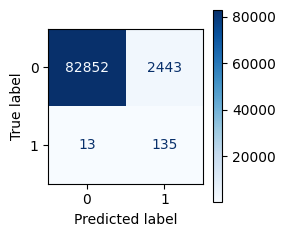

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.05      0.91      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.94      0.54     85443
weighted avg       1.00      0.97      0.98     85443



In [30]:
models = {"XGB Classifier": xgb.XGBClassifier(n_jobs=-1, tree_method="hist"),
          "XGB Random Forest Classifier": xgb.XGBRFClassifier(n_jobs=-1, tree_method="hist"),
          "Logistic Regression": LogisticRegression(n_jobs=-1),
          "KNN": KNeighborsClassifier(n_jobs=-1), 
          "Decision Tree": DecisionTreeClassifier(),
          "SGD": SGDClassifier(n_jobs=-1, loss="log_loss")}
print_scores(models, X_train=X_train_resampled, y_train=y_train_resampled,result_prefix="_smote")

VotingClassifier


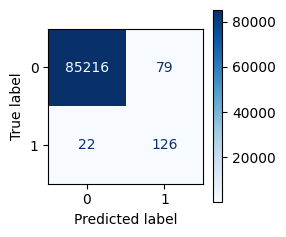

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.61      0.85      0.71       148

    accuracy                           1.00     85443
   macro avg       0.81      0.93      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [31]:
classifiers =[("XGB Classifier", xgb.XGBClassifier(n_jobs=-1, tree_method="hist")), 
                 ("XGB Random Forest Classifier", xgb.XGBRFClassifier(n_jobs=-1, tree_method="hist")),
                 ("Logistic Regression", LogisticRegression(n_jobs=-1)), 
                 ("KNN", KNeighborsClassifier(n_jobs=-1)), 
                 ("Decision Tree", DecisionTreeClassifier()),
                 ("SGD", SGDClassifier(loss="log_loss", n_jobs=-1))]

vc ={"Vote": VotingClassifier(estimators=classifiers,voting="soft",n_jobs=-1) }    
print_scores(vc, X_train=X_train_resampled, y_train=y_train_resampled, result_prefix="_voting_smote")

VotingClassifier


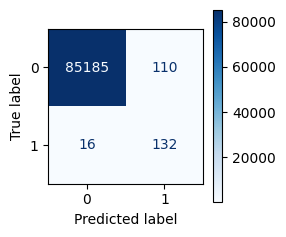

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.55      0.89      0.68       148

    accuracy                           1.00     85443
   macro avg       0.77      0.95      0.84     85443
weighted avg       1.00      1.00      1.00     85443



In [32]:
classifiers =[("XGB Classifier", xgb.XGBClassifier(n_jobs=-1, tree_method="hist")), 
                 #("XGB Random Forest Classifier", xgb.XGBRFClassifier(n_jobs=-1, tree_method="hist")),
                 ("Logistic Regression", LogisticRegression(n_jobs=-1)), 
                 ("KNN", KNeighborsClassifier(n_jobs=-1)), 
                 #("Decision Tree", DecisionTreeClassifier()),
                 ("SGD", SGDClassifier(loss="log_loss", n_jobs=-1))]

vc ={"Vote": VotingClassifier(estimators=classifiers,voting="soft",n_jobs=-1) }    
print_scores(vc, X_train=X_train_resampled, y_train=y_train_resampled, result_prefix="_voting2_smote")

Let's see if we can get any better by tuning.

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.833 total time=   4.5s
[CV 2/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.787 total time=   4.6s
[CV 3/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.857 total time=   4.6s
[CV 4/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.882 total time=   4.6s
[CV 1/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.809 total time=   4.0s
[CV 2/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.787 total time=   4.0s
[CV 3/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.847 total time=   4.0s
[CV 4/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.854 total time=   4.0s
[CV 1/4] END metric=minkowski, n_neighbors=3, weights=

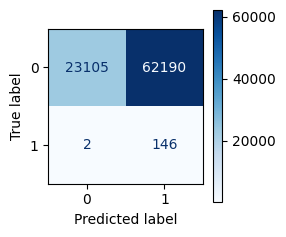

              precision    recall  f1-score   support

           0       1.00      0.27      0.43     85295
           1       0.00      0.99      0.00       148

    accuracy                           0.27     85443
   macro avg       0.50      0.63      0.22     85443
weighted avg       1.00      0.27      0.43     85443

KNeighborsClassifier


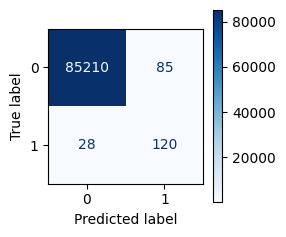

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.59      0.81      0.68       148

    accuracy                           1.00     85443
   macro avg       0.79      0.90      0.84     85443
weighted avg       1.00      1.00      1.00     85443

LogisticRegression


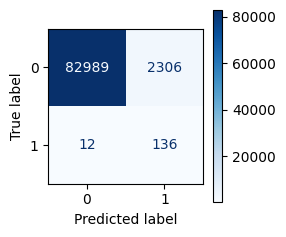

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.92      0.11       148

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.97      0.98     85443

XGBClassifier


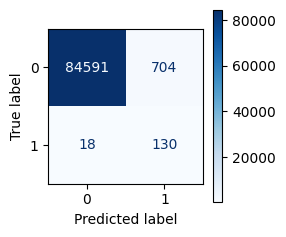

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.16      0.88      0.26       148

    accuracy                           0.99     85443
   macro avg       0.58      0.94      0.63     85443
weighted avg       1.00      0.99      0.99     85443



In [33]:
log_reg_smote_f1 = tune_leg_reg(X=X_train_resampled, y=y_train_resampled)
tree_clf_smote_f1 = tune_dec_tree(X=X_train_resampled, y=y_train_resampled)
knears_neighbors_smote_f1 = tune_knn(X=X_train_resampled, y=y_train_resampled)
xgb_est_smote_f1 = tune_xgb(X=X_train_resampled, y=y_train_resampled)
models_with_params={"Decision Tree": tree_clf_smote_f1, 
                    "KNN": knears_neighbors_smote_f1,
                    "Logistic Regression": log_reg_smote_f1, 
                    "XGB": xgb_est_smote_f1}
print_scores(models_with_params, X_train=X_train_resampled, y_train=y_train_resampled, result_prefix="_smote_tuned_f1")

VotingClassifier


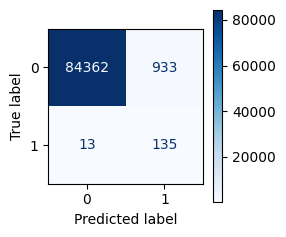

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.13      0.91      0.22       148

    accuracy                           0.99     85443
   macro avg       0.56      0.95      0.61     85443
weighted avg       1.00      0.99      0.99     85443



In [34]:
classifiers =[("XGB Classifier", xgb_est_smote_f1), 
                 ("Logistic Regression", log_reg_smote_f1), 
                 ("KNN", knears_neighbors_smote_f1), 
                 ("Decision Tree", tree_clf_smote_f1)]
vc ={"Vote": VotingClassifier(estimators=classifiers,voting="soft",n_jobs=-1) }    
print_scores(vc, X_train=X_train_resampled, y_train=y_train_resampled, result_prefix="_voting_smote_tuned_f1")

If we switch scoring to recall:

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.833 total time=   4.5s
[CV 2/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.787 total time=   4.5s
[CV 3/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.857 total time=   4.5s
[CV 4/4] END metric=minkowski, n_neighbors=2, weights=uniform;, score=0.882 total time=   4.5s
[CV 1/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.809 total time=   3.9s
[CV 2/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.787 total time=   3.9s
[CV 3/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.847 total time=   4.0s
[CV 4/4] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.854 total time=   4.0s
[CV 1/4] END metric=minkowski, n_neighbors=3, weights=

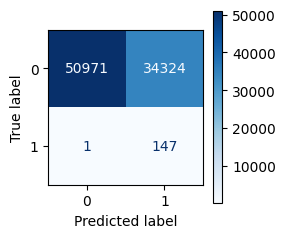

              precision    recall  f1-score   support

           0       1.00      0.60      0.75     85295
           1       0.00      0.99      0.01       148

    accuracy                           0.60     85443
   macro avg       0.50      0.80      0.38     85443
weighted avg       1.00      0.60      0.75     85443

KNeighborsClassifier


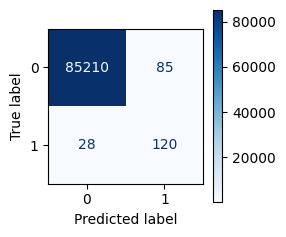

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.59      0.81      0.68       148

    accuracy                           1.00     85443
   macro avg       0.79      0.90      0.84     85443
weighted avg       1.00      1.00      1.00     85443

LogisticRegression


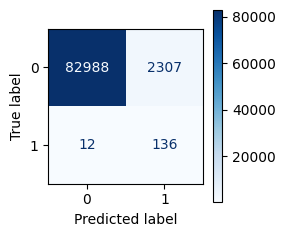

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.92      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.97      0.98     85443

XGBClassifier


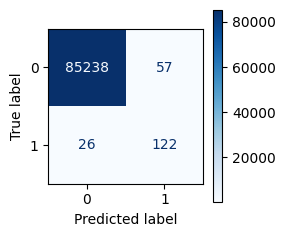

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.68      0.82      0.75       148

    accuracy                           1.00     85443
   macro avg       0.84      0.91      0.87     85443
weighted avg       1.00      1.00      1.00     85443



In [35]:
log_reg_smote_recall = tune_leg_reg(X=X_train_resampled, y=y_train_resampled)
tree_clf_smote_recall = tune_dec_tree(X=X_train_resampled, y=y_train_resampled)
knears_neighbors_smote_recall = tune_knn(X=X_train_resampled, y=y_train_resampled)
xgb_est_smote_recall = tune_xgb(X=X_train_resampled, y=y_train_resampled)
models_with_params={"Decision Tree": tree_clf_smote_recall, 
                    "KNN": knears_neighbors_smote_recall,
                    "Logistic Regression": log_reg_smote_recall, 
                    "XGB": xgb_est_smote_recall}
print_scores(models_with_params, X_train=X_train_resampled, y_train=y_train_resampled, result_prefix="_smote_recall")

VotingClassifier


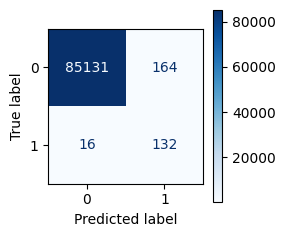

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.45      0.89      0.59       148

    accuracy                           1.00     85443
   macro avg       0.72      0.94      0.80     85443
weighted avg       1.00      1.00      1.00     85443



In [36]:
classifiers =[("XGB Classifier", xgb_est_smote_recall), 
                 ("Logistic Regression", log_reg_smote_recall), 
                 ("KNN", knears_neighbors_smote_recall), 
                 ("Decision Tree", tree_clf_smote_recall)]
vc ={"Vote": VotingClassifier(estimators=classifiers, voting="soft",n_jobs=-1) }    
print_scores(vc, X_train=X_train_resampled, y_train=y_train_resampled, result_prefix="_voting_smote_tuned_recall")

Let's apply Random Under Sampling:

In [37]:
print(np.unique(y_train, return_counts=True))
size_of_fraud_trans = np.unique(y_train, return_counts=True)[1][1]

(array([0, 1], dtype=int64), array([199020,    344], dtype=int64))


In [38]:
np.random.seed(0)
random_rows=np.random.randint(0,high=y_train.shape[0]-np.where(y_train==1)[0].shape[0], size=size_of_fraud_trans);

In [39]:
random_rows.shape

(344,)

In [40]:
np.where(y_train==1)[0].shape

(344,)

In [41]:
fraud_rows = np.where(y_train==1)[0]
non_fraud_rows = np.where(y_train==0)[0][random_rows]
selected_rows = np.concatenate((fraud_rows, non_fraud_rows), axis=0)

In [42]:
X_scaled_train_rus=X_train_scaled[selected_rows]
y_train_rus=y_train[selected_rows]

In [43]:
X_scaled_train_rus.shape

(688, 30)

In [44]:
y_train_rus.shape

(688,)

In [45]:
np.unique(y_train_rus, return_counts=True)

(array([0, 1], dtype=int64), array([344, 344], dtype=int64))

In [46]:
new_df=pd.DataFrame(X_scaled_train_rus)
new_df["Class"]=y_train_rus
new_df["Class"]=new_df["Class"].astype("int")#For correlation matrix

Let's see correlation matrix. (We did this right after Random Under Sampling to see correlations clearly.)

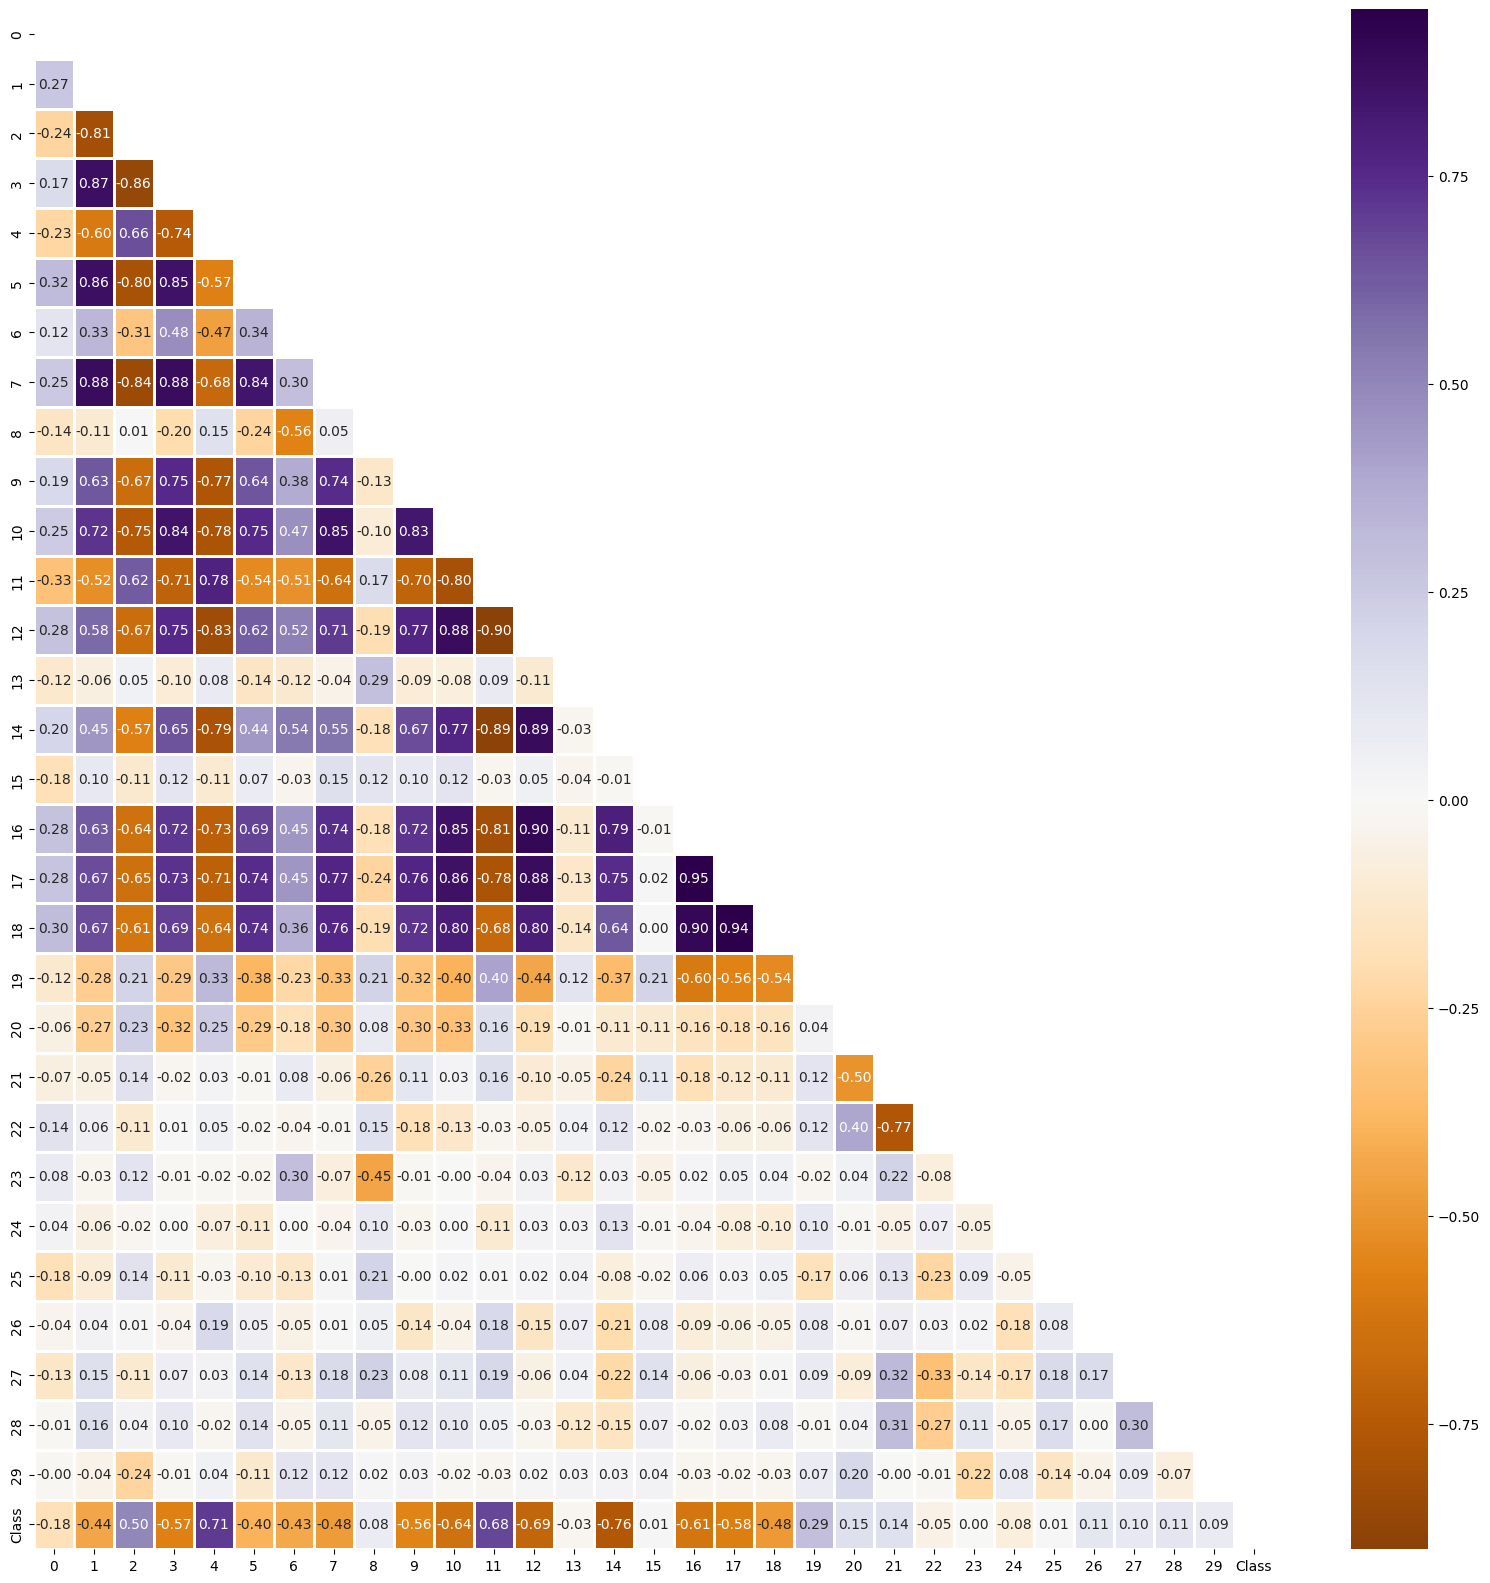

In [47]:
plt.figure(figsize = (20,20))
corr = new_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))# Generate a mask for the upper triangle 
ax = sns.heatmap(corr, cmap='PuOr', mask=mask, center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

Now try algorithms and Voting Classifier:

XGBClassifier


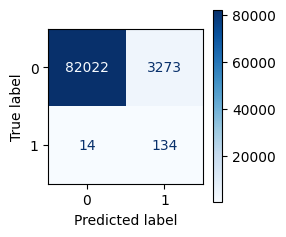

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85295
           1       0.04      0.91      0.08       148

    accuracy                           0.96     85443
   macro avg       0.52      0.93      0.53     85443
weighted avg       1.00      0.96      0.98     85443

XGBRFClassifier


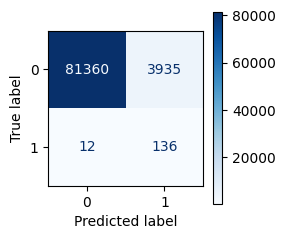

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     85295
           1       0.03      0.92      0.06       148

    accuracy                           0.95     85443
   macro avg       0.52      0.94      0.52     85443
weighted avg       1.00      0.95      0.97     85443

LogisticRegression


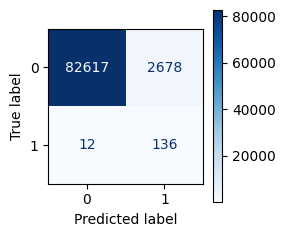

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85295
           1       0.05      0.92      0.09       148

    accuracy                           0.97     85443
   macro avg       0.52      0.94      0.54     85443
weighted avg       1.00      0.97      0.98     85443

KNeighborsClassifier


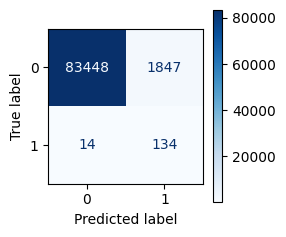

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.91      0.13       148

    accuracy                           0.98     85443
   macro avg       0.53      0.94      0.56     85443
weighted avg       1.00      0.98      0.99     85443

DecisionTreeClassifier


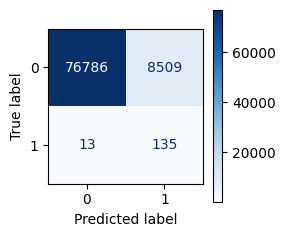

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     85295
           1       0.02      0.91      0.03       148

    accuracy                           0.90     85443
   macro avg       0.51      0.91      0.49     85443
weighted avg       1.00      0.90      0.95     85443

SGDClassifier


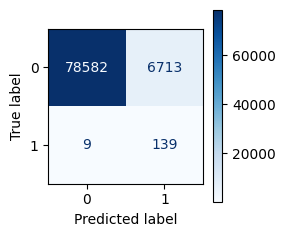

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     85295
           1       0.02      0.94      0.04       148

    accuracy                           0.92     85443
   macro avg       0.51      0.93      0.50     85443
weighted avg       1.00      0.92      0.96     85443

SVC


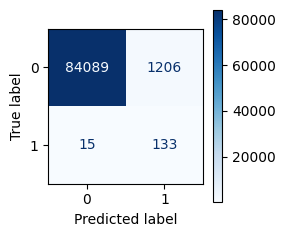

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.10      0.90      0.18       148

    accuracy                           0.99     85443
   macro avg       0.55      0.94      0.59     85443
weighted avg       1.00      0.99      0.99     85443



In [48]:
models = {"XGB Classifier": xgb.XGBClassifier(n_jobs=-1, tree_method="hist"),
          "XGB Random Forest Classifier": xgb.XGBRFClassifier(n_jobs=-1, tree_method="hist"),
          "Logistic Regression": LogisticRegression(n_jobs=-1),
          "KNN": KNeighborsClassifier(n_jobs=-1), 
          "Decision Tree": DecisionTreeClassifier(),
          "SGD": SGDClassifier(loss="log_loss", n_jobs=-1),
          "Support Vector Classifier":SVC(probability=True)}
print_scores(models, X_train=X_scaled_train_rus, y_train=y_train_rus, result_prefix="_rus")

VotingClassifier


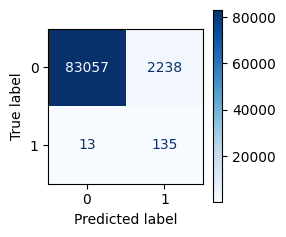

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.91      0.11       148

    accuracy                           0.97     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.97      0.99     85443



In [49]:
classifiers_rec =[("XGB Classifier", xgb.XGBClassifier(n_jobs=-1, tree_method="hist")), 
                 ("XGB Random Forest Classifier", xgb.XGBRFClassifier(n_jobs=-1, tree_method="hist")),
                 ("Logistic Regression", LogisticRegression(n_jobs=-1)), 
                 ("KNN", KNeighborsClassifier(n_jobs=-1)), 
                 ("Support Vector Classifier", SVC(probability=True))]

vc_rec ={"Vote": VotingClassifier(estimators=classifiers_rec,voting="soft",n_jobs=-1) }    
print_scores(vc_rec, X_train=X_scaled_train_rus, y_train=y_train_rus, result_prefix="_voting_rus")

In [50]:
pd.set_option('display.float_format', '{:.2f}'.format)
results

,Function Name,Accuracy,Precision,Recall,F1,TN,FP,FN,TP
0,XGBClassifier_weighted,1.00,9.34e-01,0.77,8.44e-01,85287,8,34,114
1,XGBRFClassifier_weighted,1.00,9.31e-01,0.73,8.18e-01,85287,8,40,108
2,LogisticRegression_weighted,1.00,3.22e-01,0.87,4.70e-01,85023,272,19,129
3,KNeighborsClassifier_weighted,1.00,9.15e-01,0.73,8.12e-01,85285,10,40,108
4,DecisionTreeClassifier_weighted,1.00,7.23e-01,0.72,7.23e-01,85254,41,41,107
5,SGDClassifier_weighted,0.99,2.07e-01,0.89,3.35e-01,84793,502,17,131
6,VotingClassifier_voting1,1.00,3.36e-01,0.87,4.85e-01,85040,255,19,129
7,VotingClassifier_voting2,1.00,9.22e-01,0.80,8.55e-01,85285,10,30,118
8,DecisionTreeClassifier_tuned_f1,1.00,6.90e-01,0.80,7.40e-01,85242,53,30,118
9,KNeighborsClassifier_tuned_f1,1.00,9.40e-01,0.74,8.30e-01,85288,7,38,110


In [52]:
results.to_excel('results.xls', index=False)